In [1]:
import pandas as pd
from pandas.io.json import json_normalize
from pymongo import MongoClient
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats  
import scipy.stats as st
import statsmodels as sm
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import json
from bson.json_util import dumps
import urllib.parse

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
MONGODB_HOST = pd.read_csv('./database/auth')['host'][0]
username = urllib.parse.quote_plus(pd.read_csv('./database/auth')['username'][0])
password = urllib.parse.quote_plus(pd.read_csv('./database/auth')['password'][0])
conn = MongoClient('mongodb://%s:%s@%s' % (username, password, MONGODB_HOST))

conn.database_names()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: database_names is deprecated. Use list_database_names instead.
  


['AU',
 'CYCU_1031SP',
 'CYCU_1032OS',
 'CYCU_1041SP',
 'CYCU_1042OS',
 'CYCU_1051SP',
 'CYCU_1052OS',
 'KU',
 'KU_dataset_1',
 'KU_dataset_2',
 'KyoU',
 'NCU_1071MATH',
 'NCU_CHKA',
 'NCU_CHKB',
 'NCU_ETS',
 'NCU_FC',
 'NCUx107_Pre_college_calculas',
 'OULAD',
 'Warn',
 'admin',
 'config',
 'local']

# NCUx

### NCUx - Freshman calculas

In [3]:
db = conn['KU']
collection_list = db.collection_names()

coll_list = [x for x in collection_list if 'QuizScore' in x]
coll_list

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  


['Course_34451e8c77_QuizScore',
 'Course_792efa2c1b_QuizScore',
 'Course_dbed6c966a_QuizScore',
 'Course_86066cba6d_QuizScore',
 'Course_60ab104927_QuizScore',
 'Course_6b1900c56c_QuizScore',
 'Course_65bb6224af_QuizScore',
 'Course_39a67f80f4_QuizScore',
 'Course_9a683161f5_QuizScore',
 'Course_24a65f29b6_QuizScore']

In [4]:
xmin, xmax = 60, 100
lnspc = np.linspace(xmin, xmax, 100)

arr_score = []
arr_pdf = []
for x in range(0, len(coll_list)):
    
    score_df = pd.DataFrame(list(db[coll_list[x]].find()))['score'].astype(int)
    m, s = stats.norm.fit(score_df)  
    
    score_pdf = stats.norm.pdf(lnspc, m, s)
    arr_pdf.append(score_pdf)
    
    ratio = format(len(score_df[score_df < 80]) / len(score_df[score_df >= 80]), '.2f')
    print(coll_list[x], ratio, len(score_pdf))

Course_34451e8c77_QuizScore 0.36 100
Course_792efa2c1b_QuizScore 0.27 100
Course_dbed6c966a_QuizScore 0.49 100
Course_86066cba6d_QuizScore 0.05 100
Course_60ab104927_QuizScore 0.20 100
Course_6b1900c56c_QuizScore 0.19 100
Course_65bb6224af_QuizScore 0.45 100
Course_39a67f80f4_QuizScore 0.26 100
Course_9a683161f5_QuizScore 0.13 100
Course_24a65f29b6_QuizScore 0.91 100


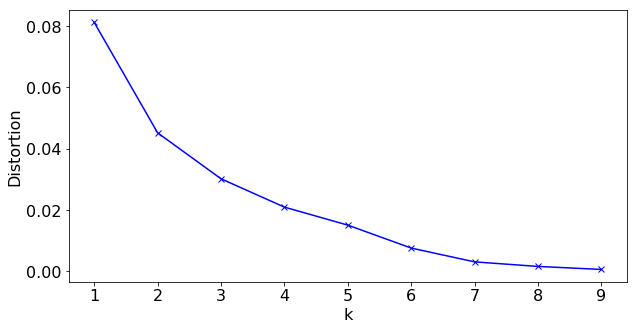

In [5]:
X = np.array(arr_pdf)
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 5))

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

lablestring = 'optimal value for k'
#plt.annotate(lablestring, xy=(3, 0.05), xytext=(3, 0.08),
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            )
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
#plt.title('The Elbow Method showing the optimal k')
#plt.savefig('./images/elbow.png', dpi=300)
plt.show()

In [6]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
labels

array([1, 2, 1, 0, 2, 2, 1, 2, 0, 1], dtype=int32)

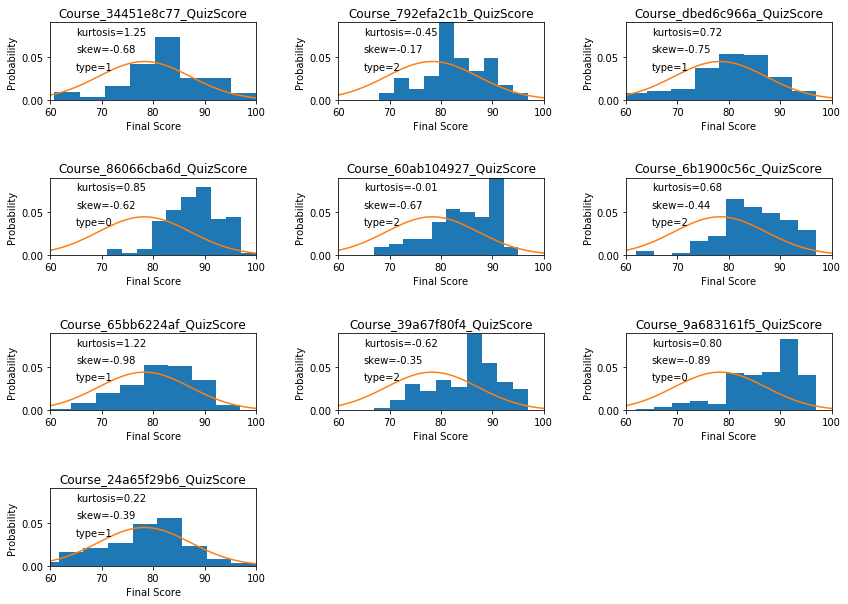

In [7]:

matplotlib.rcParams.update({'font.size': 10})
plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace=1, wspace=0.4)

label = ['Validation', 'Testing']
bins = 10
ylimit = 0.09
subplot_x = 4
subplot_y = 3

for x in range(0, len(coll_list)):
    score_df = pd.DataFrame(list(db[coll_list[x]].find()))['score'].astype(int)

    ax = plt.subplot(subplot_x, subplot_y, x+1)
    plt.hist(score_df, bins = bins, density=True)
    plt.plot(lnspc, score_pdf, label="Norm") # plot it
    plt.title(coll_list[x])
    plt.ylabel('Probability')
    plt.xlabel('Final Score')
    plt.xlim(xmin, xmax)
    plt.ylim(0, ylimit)
    
    ax.annotate('kurtosis=' + str(format(kurtosis(score_df), '.2f')), xy=(65, 0.075))
    ax.annotate('skew=' + str(format(skew(score_df), '.2f')), xy=(65, 0.055))
    ax.annotate('type=' + str(labels[x]), xy=(65, 0.035))

In [2]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [3]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

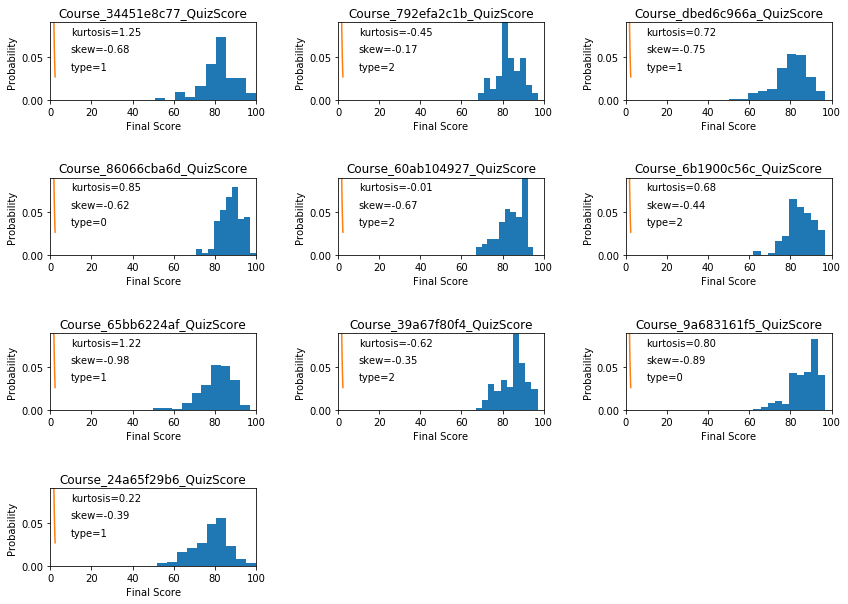

In [56]:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
matplotlib.rcParams.update({'font.size': 10})
plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace=1, wspace=0.4)

xmin, xmax = 0, 100

for x in range(0, len(coll_list)):
    score_df = pd.DataFrame(list(db[coll_list[x]].find()))['score'].astype(int)
    
    best_fit_name, best_fit_params = best_fit_distribution(score_df, 100)
    best_dist = getattr(st, best_fit_name)
    
    pdf = make_pdf(best_dist, best_fit_params)
    
    ax = plt.subplot(subplot_x, subplot_y, x+1)
    plt.hist(score_df, bins = bins, density=True)
    plt.plot(pdf_x, pdf_y, label="Norm") # plot it
    plt.title(coll_list[x])
    plt.ylabel('Probability')
    plt.xlabel('Final Score')
    plt.xlim(xmin, xmax)
    plt.ylim(0, ylimit)
    
    ax.annotate('kurtosis=' + str(format(kurtosis(score_df), '.2f')), xy=(10, 0.075))
    ax.annotate('skew=' + str(format(skew(score_df), '.2f')), xy=(10, 0.055))
    ax.annotate('type=' + str(labels[x]), xy=(10, 0.035))

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

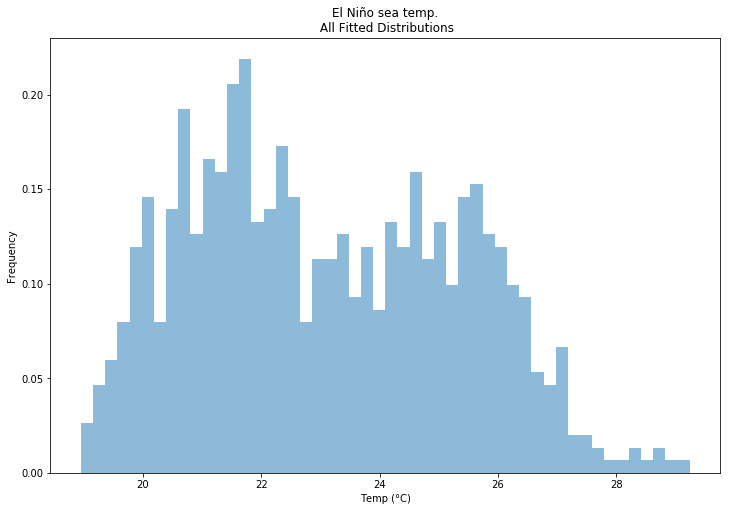

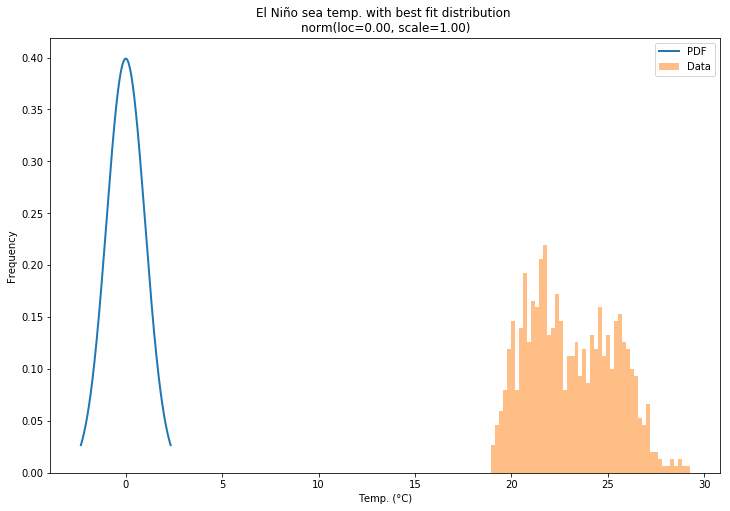

In [4]:
# Load data from statsmodels datasets
data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')